In [6]:
!pwd

/content


In [3]:
cd drive/

/content/drive


In [4]:
cd MyDrive/

/content/drive/MyDrive


In [5]:
cd deepLearning/

/content/drive/MyDrive/deepLearning


In [6]:
cd rrn/

/content/drive/MyDrive/deepLearning/rrn


In [1]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset


from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pandas as pd

import seaborn as sn

import torchvision.utils as vutils

from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import gc

In [14]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw------- 1 root root 66 Jan 23 16:01 kaggle.json


In [19]:
!kaggle datasets download -d pankrzysiu/cifar10-python

cifar10-python.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
def extractZip(zip_file):
  extract_dir = os.path.splitext(zip_file)[0]
  # os.makedirs(extract_dir)
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extractZip('cifar10-python.zip')

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.labels = labels
        self.data = data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = self.data[index]
        y = self.labels[index]

        return X, y

def prepareTestData():
  preparedImages = []
  preparedLables = []
  filePath = "cifar10-python/cifar-10-batches-py/test_batch"
  data = unpickle(filePath)
  keys = list(data.keys())

  norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

  for i in range(len(data[keys[2]])):
    image1 = np.rot90(data[keys[2]][i].reshape(3,32,32).T, k=3)
    # preparedImages.append((image1, data[keys[1]][i]))
    image1 = torch.from_numpy(image1.copy())
    image1 = image1.type(torch.FloatTensor)
    
    image1 -= torch.min(image1)
    image1 /= torch.max(image1)
    
    preparedImages.append(image1.T)
    preparedLables.append(data[keys[1]][i])
  return preparedImages, preparedLables

def prepareTrainData():
  preparedImages = []
  preparedLabels = []
  for i in range(1, 6):
    # images = prepareData("cifar10-python/cifar-10-batches-py/data_batch_" + str(i))
    filePath = "cifar10-python/cifar-10-batches-py/data_batch_" + str(i)
    data = unpickle(filePath)
    keys = list(data.keys())
    
    for i in range(len(data[keys[2]])):
      image1 = np.rot90(data[keys[2]][i].reshape(3,32,32).T, k=3)

      image1 = torch.from_numpy(image1.copy())
      image1 = image1.type(torch.FloatTensor)
      image1 -= torch.min(image1)
      image1 /= torch.max(image1)

      preparedImages.append(image1.T)
      preparedLabels.append(data[keys[1]][i])
  return preparedImages, preparedLabels


trainData, trainLabels = prepareTrainData()
testData, testLabels = prepareTestData()

train_data = Dataset(trainData, trainLabels)
train_loader = DataLoader(train_data, shuffle=True, num_workers=8, batch_size=32)

test_data = Dataset(testData, testLabels)
test_loader = DataLoader(test_data, shuffle=True, num_workers=8, batch_size=len(testData))

In [23]:
class block(nn.Module):
  def __init__(self, in_channels, intermediate_channels, position, hyper_parameters, identity_downsample=None, stride=1):
    super(block, self).__init__()
    self.position = position
    self.expansion = 4

    if hyper_parameters['regularization']:
      self.drop_out = nn.Dropout(.5)
    else:
      self.drop_out = lambda x: x

    self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)

    if hyper_parameters["batch_norm"]:
      self.bn1 = nn.BatchNorm2d(intermediate_channels)
    else:
      self.bn1 = lambda x: x

    
    self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels*self.expansion, kernel_size=3, stride=stride, padding=1)

    if hyper_parameters["batch_norm"]:
      self.bn2 = nn.BatchNorm2d(intermediate_channels*self.expansion)
    else:
      self.bn2 = lambda x: x

    self.activation_function = hyper_parameters["activation_functions"]
    self.identity_downsample = identity_downsample
    self.stride = stride
  
  def forward(self, x):
    identity = x
    x = self.conv1(x)
    if self.position != 0:
      x = self.drop_out(x)
    x = self.bn1(x)
    x = self.activation_function(x)
    x = self.conv2(x)
    if self.position != 2:
      x = self.drop_out(x)
    x = self.bn2(x)
    # x = self.relu(x)
    # x = self.conv3(x)
    # x = self.bn3(x)
  
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    
    x += identity
    x = self.activation_function(x)
    return x

class ResNet(nn.Module):
  def __init__(self, block, hyper_parameters, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64

    if hyper_parameters['regularization']:
      self.drop_out = nn.Dropout(.5)
    else:
      self.drop_out = lambda x: x

    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    if hyper_parameters["batch_norm"]:
      self.bn1 = nn.BatchNorm2d(64)
    else:
      self.bn1 = lambda x: x
    self.activation_function = hyper_parameters["activation_functions"]
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, hyper_parameters, layers[0], intermediate_channels=16, stride=1, position=0)
    self.layer2 = self._make_layer(block, hyper_parameters, layers[1], intermediate_channels=32, stride=2, position=1)
    self.layer3 = self._make_layer(block, hyper_parameters, layers[2], intermediate_channels=64, stride=2, position=1)
    self.layer4 = self._make_layer(block, hyper_parameters, layers[3], intermediate_channels=128, stride=2, position=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(128*4, num_classes)

    self.initializer = hyper_parameters['initializer']

    self.initialize_weights()

  def forward(self, x):
    

    x = self.conv1(x)
    x = self.bn1(x)

    x = self.activation_function(x)

    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, hyper_parameters, num_residual_blocks, intermediate_channels, stride, position):
    identity_downsample = None
    layers = []
    if stride != 1 or self.in_channels != intermediate_channels * 4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*4, kernel_size=1, stride=stride), nn.BatchNorm2d(intermediate_channels*4))

    layers.append(block(self.in_channels, intermediate_channels, position, hyper_parameters, identity_downsample, stride))
    self.in_channels = intermediate_channels * 4 #256

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, intermediate_channels, position, hyper_parameters))

    return nn.Sequential(*layers)

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        self.initializer(m.weight)

        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)

      # elif isinstance(m, nn.Linear):
      #   self.initializer(m.weight)

      elif isinstance(m, nn.Linear):
        self.initializer(m.weight)
        nn.init.constant_(m.bias, 0)

def ResNet20( hyper_parameters, img_channels=3, num_classes=1000):
  return ResNet(block, hyper_parameters, [6,4,6,4], img_channels, num_classes)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test():

  activation_functions = [ nn.ReLU(), nn.LeakyReLU(), nn.SELU(), nn.ELU(), nn.Hardshrink() ]

  # hyper parameter encoding: 
  # [ activation_function(nn.function()), batchnorm(bool), labelSmoothing(bool), learningRate(float), regularization(bool), initialization(?) ]

  net = ResNet20({ "activation_functions":activation_functions[0], "batch_norm":False, "learning_rate":.0005, "label_smoothing":True, "regularization":True, "initializer":nn.init.xavier_uniform_  })
  x = torch.randn(4, 3, 32, 32)
  y = net(x).to("cuda")
  return y.shape
  print("number of parameters:" + str(count_parameters(net)))
  print("Shape of output: " + str(y.shape))

test()

torch.Size([4, 1000])

In [12]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device):
    """Gets average accuracy and loss for the validation set"""

    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch 
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

    model.train()

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [13]:
def get_confussion_matrix(y_hat, y_truth):

  guesses = np.array([ torch.argmax(batch, dim=1).detach().cpu().numpy() for batch in y_hat ])

  guesses = np.reshape(guesses, guesses.shape[0] * guesses.shape[1] )

  truths = np.array([ batch.detach().cpu().numpy() for batch in y_truth ])

  truths = np.reshape(truths, truths.shape[0] * truths.shape[1] )

  cm = confusion_matrix(truths, guesses)

  cm = cm / cm.astype(np.float).sum(axis=1)

  # return cm

  ciphar10Labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

  isLabels = [ "Is " + ciphar10Labels[i] for i in range(len(ciphar10Labels)) ]
  guessLabels = [ "Guessed " + ciphar10Labels[i] for i in range(len(ciphar10Labels)) ]
  

  df_cm = pd.DataFrame(cm, index = isLabels,
                    columns = guessLabels)
  return df_cm

In [14]:

activation_functions = [ nn.ReLU(), nn.LeakyReLU(), nn.SELU(), nn.ELU(), nn.Hardshrink() ]

initializers = [ nn.init.xavier_uniform_, nn.init.orthogonal_]

vanillaHypers = { "activation_functions":activation_functions[0], "batch_norm":False, "cyclic_rate":False, "label_smoothing":False, "regularization":False, "initializer":initializers[0]  }

changes = [  ("activation_functions", activation_functions[0]), ("activation_functions", activation_functions[1]), ("activation_functions", activation_functions[2]), ("activation_functions", activation_functions[3]), ("activation_functions", activation_functions[4]), ("batch_norm", True), ("regularization", True), ("initializer", initializers[1]), ("cyclic_rate", True)   ]

for change in changes:

  moddedHypers = vanillaHypers.copy()

  # print(moddedHypers)

  moddedHypers[ change[0] ] = change[1]

  print(moddedHypers)

{'activation_functions': ReLU(), 'batch_norm': False, 'cyclic_rate': False, 'label_smoothing': False, 'regularization': False, 'initializer': <function xavier_uniform_ at 0x7f82010c8048>}
{'activation_functions': LeakyReLU(negative_slope=0.01), 'batch_norm': False, 'cyclic_rate': False, 'label_smoothing': False, 'regularization': False, 'initializer': <function xavier_uniform_ at 0x7f82010c8048>}
{'activation_functions': SELU(), 'batch_norm': False, 'cyclic_rate': False, 'label_smoothing': False, 'regularization': False, 'initializer': <function xavier_uniform_ at 0x7f82010c8048>}
{'activation_functions': ELU(alpha=1.0), 'batch_norm': False, 'cyclic_rate': False, 'label_smoothing': False, 'regularization': False, 'initializer': <function xavier_uniform_ at 0x7f82010c8048>}
{'activation_functions': Hardshrink(0.5), 'batch_norm': False, 'cyclic_rate': False, 'label_smoothing': False, 'regularization': False, 'initializer': <function xavier_uniform_ at 0x7f82010c8048>}
{'activation_functi

In [15]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
# data, labels = prepareTestData()
# train_data = Dataset(data, labels)
# data_loader = DataLoader(train_data, shuffle=True, num_workers=8, batch_size=10)

def getAvailableMemory():
  t = torch.cuda.get_device_properties(0).total_memory
  r = torch.cuda.memory_reserved(0) 
  a = torch.cuda.memory_allocated(0)
  f = r-a  # free inside reserved
  return f



def train(train_loader, test_loader, activation_function, changes, fullPrintOut = False, resetChanges=True):
  
  torch.cuda.empty_cache()
  epochs = 1
  lr = .00005
  num_classes = 10

  device = torch.device('cuda:0')

  activation_functions = [ nn.ReLU(), nn.LeakyReLU(), nn.SELU(), nn.ELU(), nn.Hardshrink() ]

  initializers = [ nn.init.xavier_uniform_, nn.init.orthogonal_]

  vanillaHypers = { "activation_functions":activation_functions[0], "batch_norm":False, "learning_rate":False, "label_smoothing":False, "regularization":False, "initializer":initializers[0], "cyclic_rate":False  }

  moddedHypers = vanillaHypers.copy()

  for iteration in range(5):

    for change in changes:

      if resetChanges:
        moddedHypers = vanillaHypers.copy()

      moddedHypers[ change[0] ] = change[1]

      model = ResNet20(moddedHypers, num_classes=num_classes)
      model = model.to(device)

      objective = nn.CrossEntropyLoss()

      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)
      
      if moddedHypers['label_smoothing']:
        objective = LabelSmoothingLoss(smoothing=.1, classes=num_classes)

      if moddedHypers['cyclic_rate']:
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-2, step_size_up=2000, cycle_momentum=False)

      train_losses = []
      train_accuricies = []

      test_losses = []
      test_accuricies = []

      count = 0

      final_guess_train = []
      truth_train = []

      final_guess_test = []
      truth_test = []

      getAvailableMemory()

      for epoch in range(epochs):
        with tqdm(total=len(train_loader), position=0, leave=True) as pbar:
          count = 0
          for x, y_truth in train_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            
            gc.collect()
            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)
            train_loss.backward()
            optimizer.step()
            if moddedHypers['cyclic_rate']:
              scheduler.step()
            train_accuricies.append(train_acc.item())
            train_losses.append(train_loss.item())
            
            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f} memory left:{:.4f} .'.format(train_loss.item(), train_acc, getAvailableMemory()))
            pbar.update(1)

            count += 1
            if count == 5000:
              break
                        
            x.detach()
            y_truth.detach()
            y_hat.detach()
            gc.collect()
            # final_guess_train.append(y_hat)
            # truth_train.append(y_truth)
            del x
            del y_truth
            del y_hat

      for x, y_truth in test_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        
        y_hat = model(x)
        test_loss = objective(y_hat, y_truth).item()
        test_acc = accuracy(y_hat, y_truth).item()
        # return None

      pbar.close()  

      trainOutputDF = pd.DataFrame()

      trainOutputDF['accuricies'] = train_accuricies
      trainOutputDF['losses'] = train_losses

      

      testOutputDF = pd.DataFrame()
      testOutputDF['accuricies'] = [test_acc]
      testOutputDF['losses'] = [test_loss]
      
      

      if resetChanges:
        pass
        # trainOutputDF.to_csv( "train/train_" + change[0] + "_" + str(change[1]) + "_iteration_" + str(iteration) + ".csv" )
        # testOutputDF.to_csv( "test/test_" + change[0] + "_" + str(change[1]) + "_iteration_" + str(iteration) + ".csv" )
      else:
        trainOutputDF.to_csv( "trainAccum/train_" + change[0] + "_" + str(change[1]) + "_iteration_" + str(iteration) + ".csv" )
        testOutputDF.to_csv( "testAccum/test_" + change[0] + "_" + str(change[1]) + "_iteration_" + str(iteration) + ".csv" )

      print(change[0] + " complete")

      if fullPrintOut:
        count = 0
        for x, y_truth in test_loader:
            with tqdm(total=len(test_loader), position=0, leave=True) as pbar:
              x, y_truth = x.to(device), y_truth.to(device)        
              gc.collect()
              optimizer.zero_grad()
              y_hat = model(x)
              train_loss = objective(y_hat, y_truth)
              test_acc = accuracy(y_hat, y_truth)
              test_accuricies.append(test_acc)
              test_losses.append(train_loss.item())
              
              pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f} memory left:{:.4f} .'.format(train_loss.item(), test_acc, getAvailableMemory()))
              pbar.update(1)

              x.detach()
              y_truth.detach()
              y_hat.detach()
              gc.collect()
              final_guess_test.append(y_hat)
              truth_test.append(y_truth)
              # if count == 3:
              #   break
              del x
              del y_truth
              del y_hat

              count += 1

              if count == 5000:
                break

        pbar.close()

        fig, axs = plt.subplots(4, figsize=(8,6))

        axs[0].plot(np.arange(len(train_accuricies)), train_accuricies, label='Train Accuracy')
        axs[0].legend()
        axs[0].set_title("Train Accuracy")
        
        axs[1].plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
        axs[1].legend()
        axs[1].set_title("Train Loss")


        axs[2].plot(np.arange(len(test_accuricies)), test_accuricies, label='Test Accuracy')
        axs[2].legend()
        axs[2].set_title("Test Accuracy")
        
        axs[3].plot(np.arange(len(test_losses)), test_losses, label='Test Loss')
        axs[3].legend()
        axs[3].set_title("Test Loss")

        plt.tight_layout()

        newCMMatix = get_confussion_matrix(final_guess_train, truth_train)
        plt.figure(figsize = (9,9))
        plt.title("Test Confusion")
        sn.heatmap(newCMMatix, annot=True)

        newCMMatix = get_confussion_matrix(final_guess_test, truth_test)
        plt.figure(figsize = (9,9))
        plt.title("Train Confusion")
        sn.heatmap(newCMMatix, annot=True)
        plt.tight_layout()

activation_functions = ["relu", "leakyrelu", "selu", "elu", "hardshrink"]

activation_functions = [ nn.ReLU(), nn.LeakyReLU(), nn.SELU(), nn.ELU(), nn.Hardshrink() ]

initializers = [ nn.init.xavier_uniform_, nn.init.orthogonal_]

changes =  [("activation_functions", activation_functions[0]), ("activation_functions", activation_functions[3]), ("learning_rate", True), ("initializer", initializers[1]), ("label_smoothing", True), ("batch_norm", True), ("regularization", True)]

train(train_loader, test_loader, activation_functions[0], changes, fullPrintOut = False, resetChanges=False)

train loss:1.7270, train accuracy:0.2500 memory left:2126747136.0000 .: 100%|██████████| 1563/1563 [04:33<00:00,  5.73it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

activation_functions complete


train loss:1.2121, train accuracy:0.5000 memory left:7700936192.0000 .: 100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

activation_functions complete


train loss:1.4120, train accuracy:0.5000 memory left:7700436480.0000 .: 100%|██████████| 1563/1563 [04:28<00:00,  5.83it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

learning_rate complete


train loss:1.7022, train accuracy:0.3125 memory left:7700035072.0000 .: 100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


initializer complete


train loss:1.7990, train accuracy:0.5625 memory left:7699633664.0000 .: 100%|██████████| 1563/1563 [04:28<00:00,  5.83it/s]


label_smoothing complete


train loss:1.9236, train accuracy:0.4375 memory left:7702210560.0000 .: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s]


batch_norm complete


train loss:2.2635, train accuracy:0.1250 memory left:8633763840.0000 .: 100%|██████████| 1563/1563 [05:04<00:00,  5.13it/s]


regularization complete


train loss:2.1954, train accuracy:0.0938 memory left:8633189888.0000 .:  70%|███████   | 1101/1563 [03:34<01:29,  5.14it/s]

In [3]:
def getFilePaths(has=None, hasNot=None):

  preFilesToProcess = []
  filesToProcess = []
  for (dirpath, dirnames, filenames) in os.walk('./'):
      preFilesToProcess = preFilesToProcess + [ dirpath + "/" + file for file in filenames ]

  for file in preFilesToProcess:
    go = True

    if not has is None:
      for el in has:
        if file.find(el) == -1:
          go = False
          break

    if not go:
      continue

    if not hasNot is None:
      for el in hasNot:
        if file.find(el) != -1:
          go = False
          break

    if not go:
      continue

    filesToProcess.append(file)

  return filesToProcess


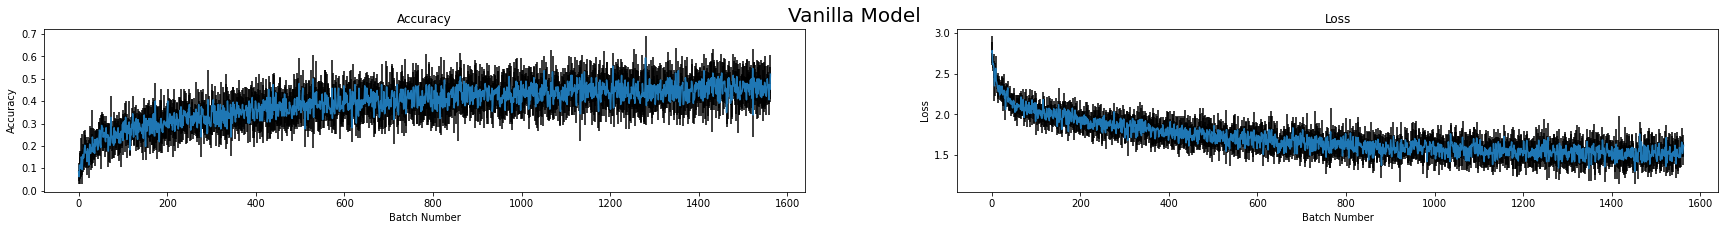

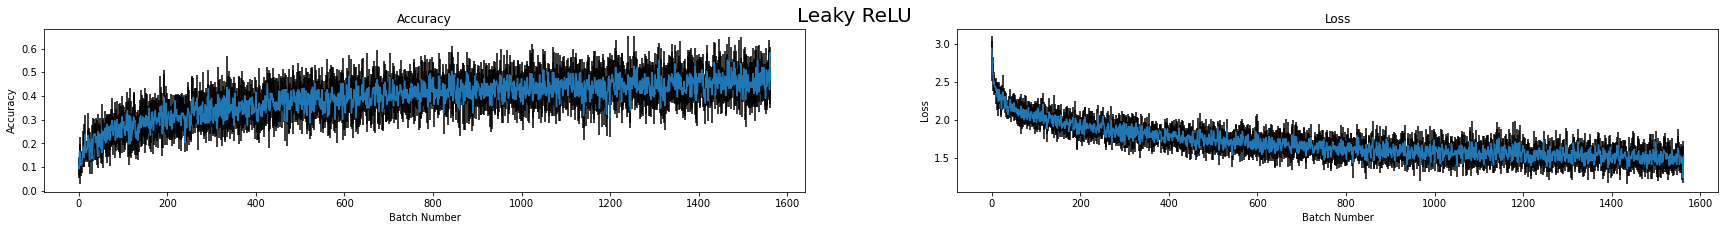

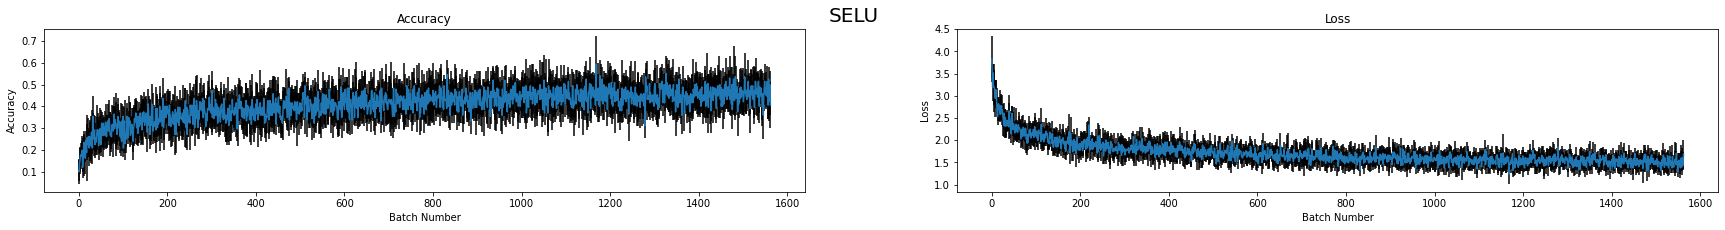

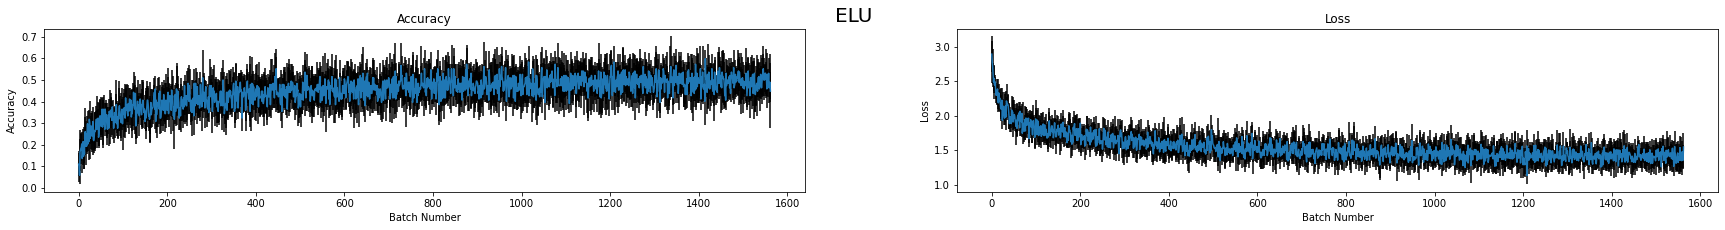

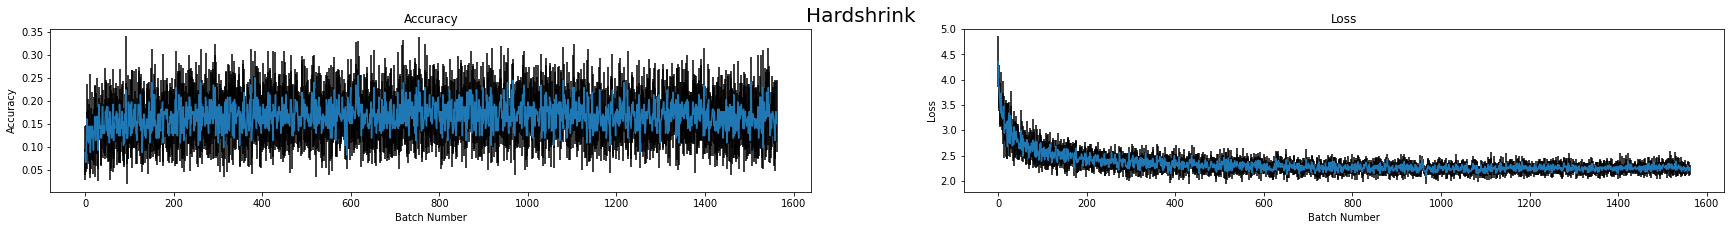

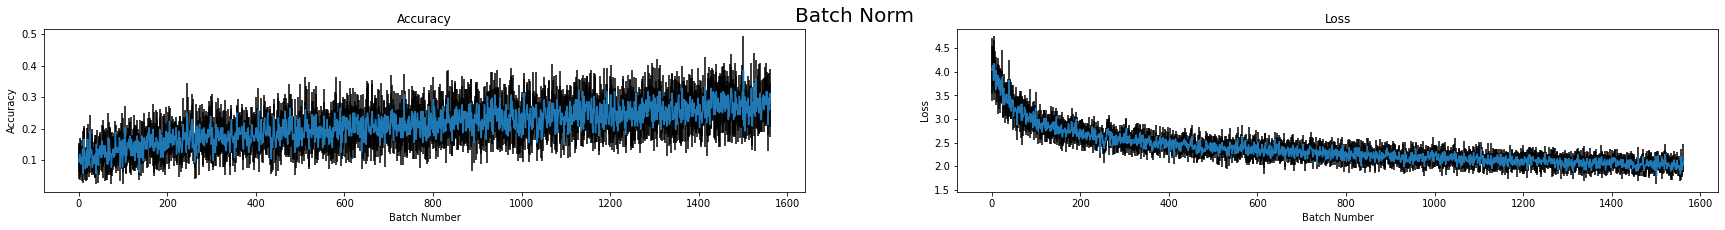

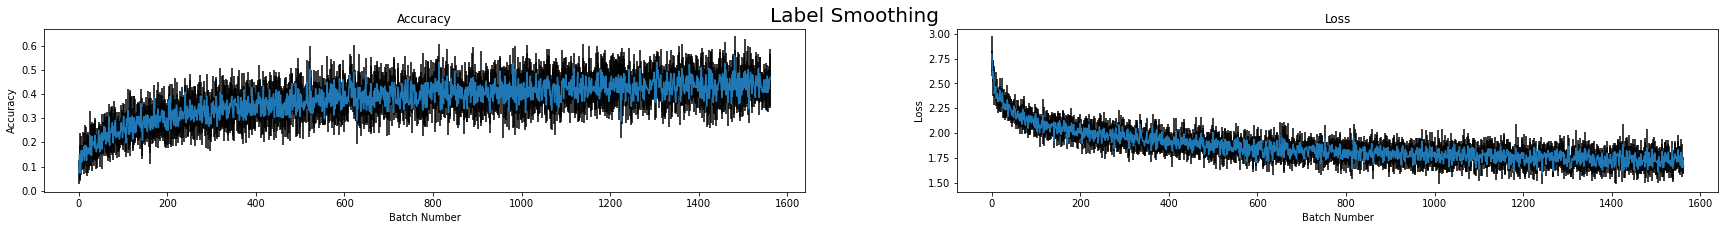

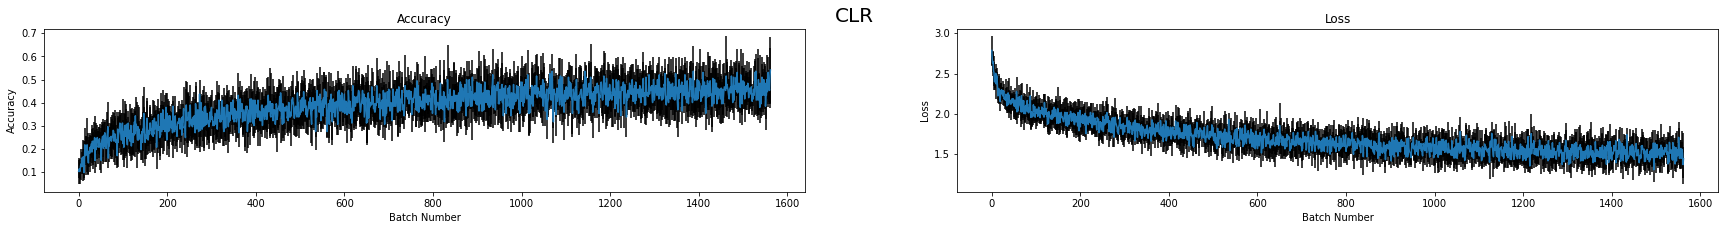

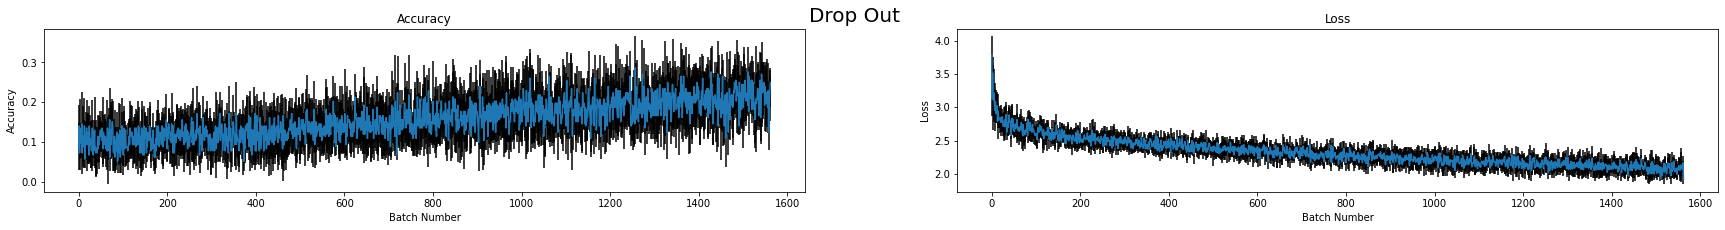

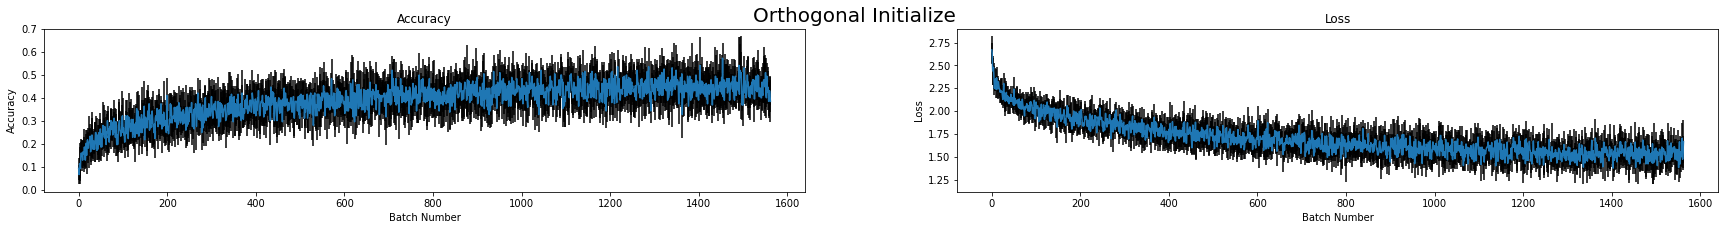

In [8]:

def graphTrainCases(accumilative, file_types, file_type_names):

  # file_types = np.array(['_ReLU()', "batch_norm", "learning_rate", "label_smoothing", "regularization", "initializer", "cyclic_rate", 'LeakyReLU', 'SELU(', '_ELU(', 'Hardshrink'])
  

  finalAccurMean = []
  finalAccurSTD = []

  finalLossMean = []
  finalLossSTD = []

  for fileType in file_types:
    if accumilative:
      filesToProcess =  getFilePaths([ '.csv', '/trainAccum/', 'train_', fileType ], ['train_results'])
    else:
      filesToProcess =  getFilePaths([ '.csv', '/train/', 'train_', fileType ], ['train_results'])

    # print(len(filesToProcess))
    accuricies = []
    losses = []
    
    for i, file in enumerate(filesToProcess):
      if i > 5:
        continue
      accuricies.append(pd.read_csv(file)['accuricies'].to_numpy())
      losses.append(pd.read_csv(file)['losses'].to_numpy())

    accuricies = np.array(accuricies)
    losses = np.array(losses)


    finalAccurMean.append(np.mean(accuricies, axis=0))
    finalAccurSTD.append(np.std(accuricies, axis=0))
    # return None
    finalLossMean.append(np.mean(losses, axis=0))
    finalLossSTD.append(np.std(losses, axis=0))

  for i in range(len(finalAccurMean)):

    fig, axs = plt.subplots(1,2, figsize=(30,3))

    fig.suptitle(file_type_names[i], fontsize=20)

    axs[0].errorbar( np.arange(len(finalAccurMean[i])), finalAccurMean[i], yerr=finalAccurSTD[i], capthick=5, errorevery=1, ecolor='black' )
    axs[1].errorbar( np.arange(len(finalLossMean[i])), finalLossMean[i], yerr=finalLossSTD[i], capthick=5, errorevery=1, ecolor='black')
    
    axs[0].set_xlabel("Batch Number")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy")
    
    axs[1].set_xlabel("Batch Number")
    axs[1].set_ylabel("Loss")
    axs[1].set_title("Loss")

file_types = np.array(['_ReLU()', 'LeakyReLU', 'SELU(', '_ELU(', 'Hardshrink', "batch_norm", "label_smoothing", "learning_rate", "regularization", "initializer"])

file_type_names = np.array([ "Vanilla Model", "Leaky ReLU", "SELU", "ELU", "Hardshrink", "Batch Norm", "Label Smoothing", "CLR", "Drop Out", "Orthogonal Initialize"])

graphTrainCases(False, file_types, file_type_names)


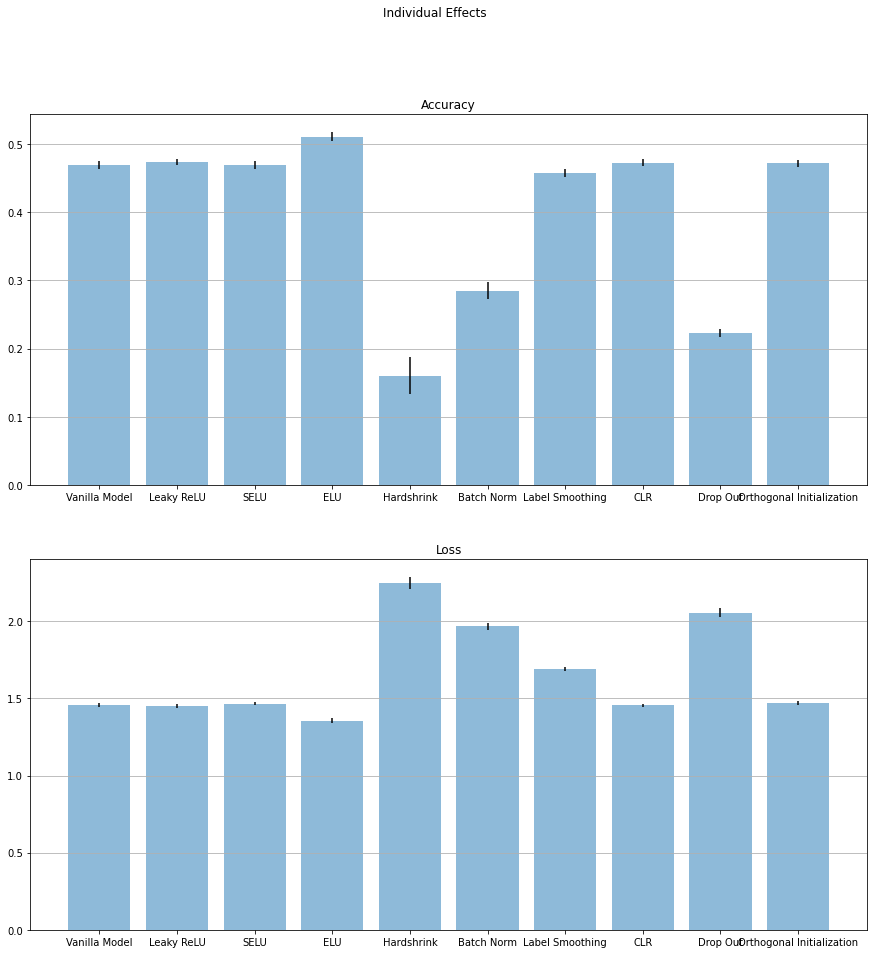

In [7]:

def graphTestCases(accumilative, file_types, file_type_names, superTitle):

  finalAccurMean = []
  finalAccurSTD = []

  finalLossMean = []
  finalLossSTD = []
  

  for fileType in file_types:
    if accumilative:
      filesToProcess =  getFilePaths([ '.csv', '/testAccum/', fileType ])
    else:
      filesToProcess =  getFilePaths([ '.csv', '/test/', fileType ])
    # print(len(filesToProcess))
    accuriciesMean = []
    accuriciesSTD = []

    lossesMean = []
    lossesSTD = []
    
    for i, file in enumerate(filesToProcess):
      if i > 5:
        continue
      
      accuriciesMean.append(pd.read_csv(file)['accuricies'].to_numpy().mean())
      accuriciesSTD.append(pd.read_csv(file)['accuricies'].to_numpy().std())


      lossesMean.append(pd.read_csv(file)['losses'].to_numpy())
      lossesSTD.append(pd.read_csv(file)['losses'].to_numpy())
        
    finalAccurMean.append(np.mean(accuriciesMean))
    finalAccurSTD.append(np.std(accuriciesMean))

    finalLossMean.append(np.mean(lossesMean))
    finalLossSTD.append(np.std(lossesMean))


  fig, axs = plt.subplots(2, figsize=(15,15))

  fig.suptitle(superTitle)

  axs[0].bar(np.arange(len(finalAccurMean)), finalAccurMean, yerr=finalAccurSTD, align='center', alpha=0.5, ecolor='black')
  

  axs[1].bar(np.arange(len(finalLossMean)),finalLossMean, yerr=finalLossSTD, align='center', alpha=0.5, ecolor='black')

  axs[0].set_xticks(np.arange(len(finalAccurMean)))
  axs[1].set_xticks(np.arange(len(finalAccurMean)))
  
  axs[0].set_xticklabels(file_type_names)
  axs[1].set_xticklabels(file_type_names)
  
  axs[0].yaxis.grid(True)
  axs[1].yaxis.grid(True)

  axs[0].set_title("Accuracy")

  axs[1].set_title("Loss")



file_types = np.array(['_ReLU()', 'LeakyReLU', 'SELU(', '_ELU(', 'Hardshrink', "batch_norm", "label_smoothing", "learning_rate", "regularization", "initializer"])

file_type_names = np.array([ "Vanilla Model", "Leaky ReLU", "SELU", "ELU", "Hardshrink", "Batch Norm", "Label Smoothing", "CLR", "Drop Out", "Orthogonal Initialization" ])

graphTestCases(False, file_types, file_type_names, "Individual Effects")

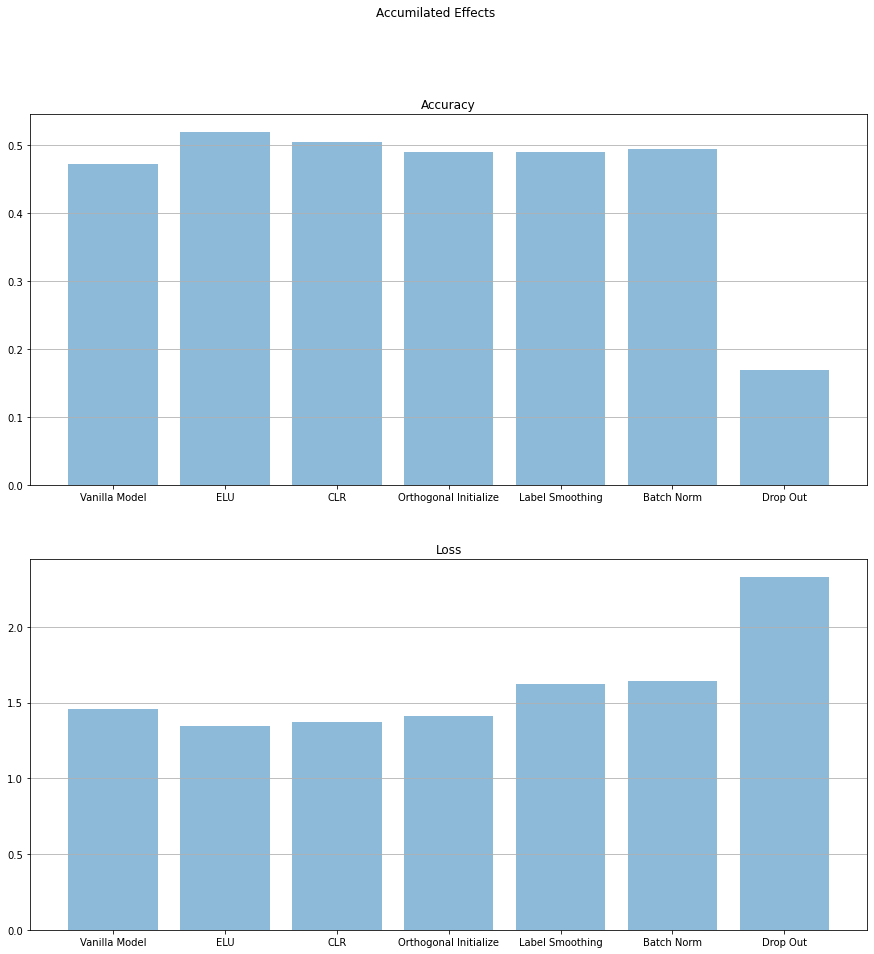

In [8]:
file_types = np.array(['_ReLU()', '_ELU(', "learning_rate", "initializer", "label_smoothing", "batch_norm", "regularization"])

file_type_names = ["Vanilla Model", "ELU", "CLR", "Orthogonal Initialize", "Label Smoothing", "Batch Norm", "Drop Out"]

graphTestCases(True, file_types, file_type_names, "Accumilated Effects")